In [1]:
import requests, json
from datetime import datetime, timedelta
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely

In [2]:
PROJECTION=32630

#### Station ridership

In [6]:
counts_en = pd.read_csv('/Users/itto/Documents/cities/data/london/counts/En17week_mod.csv', skiprows=6).set_index(' Station')
counts_ex = pd.read_csv('/Users/itto/Documents/cities/data/london/counts/Ex17week.csv', skiprows=6).set_index(' Station')

# We only care about the time columns
time_columns = counts_en.columns[4:-8]

# Easier to work with stations as columns, so transpose
data_en = counts_en.loc[:, time_columns].T
data_ex = counts_ex.loc[:, time_columns].T

# Remove "Total" column
data_en.drop('Total',axis=1,inplace=True)
data_ex.drop('Total',axis=1,inplace=True)

# Extract the first time
data_en.index = data_en.index.str[:4]
data_ex.index = data_en.index.str[:4]

# Convert to datetime format
data_en.index = pd.to_datetime(data_en.index, format='%H%M')
data_ex.index = pd.to_datetime(data_en.index, format='%H%M')

# Create a time of day index that we can use from now on
time_of_day = {
    6: 'morning',
    7: 'morning',
    8: 'morning',
    9: 'morning',
    11: 'off',
    12: 'off',
    13: 'off',
    14: 'off',
    16: 'afternoon',
    17: 'afternoon',
    18: 'afternoon',
    19: 'afternoon'
}
time_of_day = data_en.index.hour.map(time_of_day).to_series()
time_of_day[time_of_day.isnull()] = 'night'
time_of_day = time_of_day.values

In [7]:
# Get the entrances and exists for each time interval
entrances = data_en.groupby(time_of_day).sum().T
exits = data_ex.groupby(time_of_day).sum().T

In [728]:
station_geom = gpd.read_file('../data/london/shapes/stations/stations_mod.shp')
# Change to UTM
station_geom.to_crs(epsg=PROJECTION, inplace=True)
# Remove the word "Station"
station_geom.columns = station_geom.columns.str.lower()
station_geom.rename(columns={'geometry':'location'}, inplace=True)
station_geom.name = station_geom.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')
station_geom.set_index('name', drop=True, inplace=True)

# Read Voronoi cells
station_voronoi = gpd.read_file('../data/london/shapes/stations/voronoi.shp')
station_voronoi.to_crs(epsg=PROJECTION, inplace=True)
station_voronoi.columns = station_voronoi.columns.str.lower()
station_voronoi.rename(columns={'geometry':'cell'}, inplace=True)
station_voronoi.name = station_voronoi.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')
station_voronoi.set_index('name', drop=True, inplace=True)

# Combine Voronoi with location
station_geom['cell'] = station_voronoi.reindex(station_geom.index).cell


#### Combine the data

In [13]:
# Combine entrances and station locations data
stations = pd.merge(station_geom, entrances, left_index=True, right_index=True)
stations['station'] = stations.index

### Characterizing TripGo data

We will be using an API called TripGO to generate an estimate for the travel time between nodes. Before we can proceed with this API, we should check some assumptions that will be useful later:

1. Trips are symmetric. The time from A to B is the same as from B to A.
1. Trips are singular. There exists only one shortest-length trip from A to B.
1. Frequency is constant. The frequency of shortest length trips (corresponding to the headways) does not change within the morning rush and afternoon rush periods.

In [448]:
# Prepare a list of 10 random A-to-B pairs
from itertools import permutations, combinations
coords = stations.set_geometry('location').to_crs(epsg=4326).geometry

n = 10
points = coords.sample(n*2, replace=False, random_state=37)
pairs = []
names = []
for i in range(0,n*2,2):
    p1 = (points.geometry[i].y, points.geometry[i].x)
    p2 = (points.geometry[i+1].y, points.geometry[i+1].x)
    pairs.append((p1,p2))
    names.append((points.index[i], points.index[i+1]))
    # Add the inverse
    pairs.append((p2,p1))
    names.append((points.index[i+1], points.index[i]))

In [735]:
time_am = int(datetime(2018,11,21,8,0).timestamp())
time_pm = int(datetime(2018,11,21,17,0).timestamp())

In [736]:
def get_routes(depart_time, pairs):
    url = 'https://api.tripgo.com/v1/'
    
    headers = {
    'Accept': 'application/json',
    'X-TripGo-Key': '5c1a480843464d538b24939c266be8b9',
    }
    
    segments = []
    routes = []
    for i,pair in enumerate(pairs):
        print('Routing: from {} to {}'.format(names[i][0], names[i][1]))
        p2 = pair[0]
        p1 = pair[1]
        direction = i%2 # 0 for To and 1 for Return
        # Set up request
        params = (
            ('from', str(p2)),
            ('to', str(p1)),
            ('modes', 'pt_pub'),
            ('v', '11'),
            ('locale', 'en'),
            ('departAfter', depart_time - 1) #Subtract 1 since it's actually "depart after"
        )

        # Make request
        response = requests.get('https://api.tripgo.com/v1/routing.json', headers=headers, params=params)

        routing = json.loads(response.text)

        segs = pd.DataFrame(routing['segmentTemplates'])
        segs['route'] = int(i/2)
        segs['direction'] = direction
        segs['routeA'] = names[i][0]
        segs['routeB'] = names[i][1]
        segments.append(segs)

        # For all groups
        for j,group in enumerate(routing['groups']):
            df = pd.DataFrame(group['trips'])
            # Meta data
            df['route'] = int(i/2)
            df['direction'] = direction
            df['routeA'] = names[i][0]
            df['routeB'] = names[i][1]
            df['group'] = j
            df['num_segments'] = df.segments.apply(len)
            # Preliminary processing
            df['length'] = (df.arrive - df.depart)/60
            df['depart_time'] = df.depart.apply(datetime.fromtimestamp)
            df['arrive_time'] = df.arrive.apply(datetime.fromtimestamp)
            # Check if it's a completely underground route
            providers = ''
            for source in routing['groups'][j]['sources']:
                name = source['provider']['name']
                if ('Underground' not in name) and ('OpenStreetMap' not in name) and ('London Overground' not in name):
                    if len(providers):
                        providers += ', '
                    providers += name
            df['other_providers'] = providers
            routes.append(df)
    print('Complete.')
    return routes

In [738]:
%%time
routes_am = get_routes(time_am)
df_am = pd.concat(routes_am)
df_am.reset_index(inplace=True, drop=True)

routes_pm = get_routes(time_pm)
df_pm = pd.concat(routes_pm)
df_pm.reset_index(inplace=True, drop=True)

Routing: from North Acton to Kensington (Olympia)
Routing: from Kensington (Olympia) to North Acton
Routing: from Russell Square to Belsize Park
Routing: from Belsize Park to Russell Square
Routing: from Liverpool Street to South Ealing
Routing: from South Ealing to Liverpool Street
Routing: from Burnt Oak to Highbury & Islington
Routing: from Highbury & Islington to Burnt Oak
Routing: from Heathrow Terminals 1, 2, 3 to Southgate
Routing: from Southgate to Heathrow Terminals 1, 2, 3
Routing: from Osterley to Totteridge & Whetstone
Routing: from Totteridge & Whetstone to Osterley
Routing: from Theydon Bois to Upton Park
Routing: from Upton Park to Theydon Bois
Routing: from Ladbroke Grove to Hornchurch
Routing: from Hornchurch to Ladbroke Grove
Routing: from Rayners Lane to Edgware
Routing: from Edgware to Rayners Lane
Routing: from Chancery Lane to Tottenham Hale
Routing: from Tottenham Hale to Chancery Lane
Complete.
Routing: from North Acton to Kensington (Olympia)
Routing: from Kens

In [739]:
df_am['period'] = 'am'
df_pm['period'] = 'pm'
df = pd.concat([df_am, df_pm])

In [741]:
def get_full_hashcode(x):
    y = ''
    for seg in x:
        y += str(seg['segmentTemplateHashCode'])
    return y

In [742]:
def get_transport_hashcode(x):
    y = ''
    for seg in x:
        if 'serviceDirection' in seg.keys():
            y += str(seg['segmentTemplateHashCode'])
    return y

In [743]:
df['hashcode'] = df.segments.apply(get_full_hashcode)
df['hashcode_transport'] = df.segments.apply(get_transport_hashcode)

In [806]:
# Sometimes we get two routes that are identical in departure time and mode of transport. Get rid of them.
df.drop_duplicates(subset=['hashcode','depart'],inplace=True)

#### Symmetry between AM and PM trips

*Length of trips*

In [937]:
symmetry = df.groupby(['hashcode_transport','period']).length.mean().unstack()
symmetry['difference (minutes)'] = (symmetry['am'] - symmetry['pm']).abs()
symmetry['difference (percent)'] = (symmetry['am'] - symmetry['pm']).abs()/symmetry['am'] * 100

Text(0.5,1,'Difference between AM and PM (percent)')

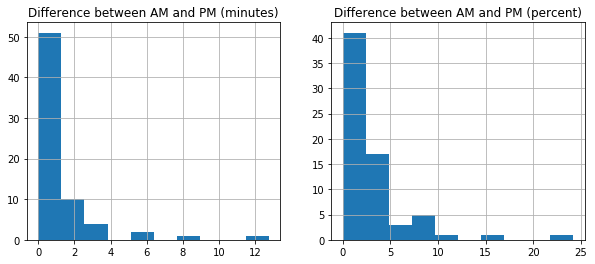

In [939]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
symmetry['difference (minutes)'].hist(ax=ax1)
ax1.set_title('Difference between AM and PM (minutes)')
symmetry['difference (percent)'].hist(ax=ax2)
ax2.set_title('Difference between AM and PM (percent)')

Therefore, for a given route and specific path, the maximum difference between AM and PM is up to 12 minutes. That being said, the difference is usually within 5 percent.

In [884]:
symmetry = df.loc[df.other_providers == ''].groupby(['route','direction','period']).length.min().unstack()
symmetry['difference (minutes)'] = (symmetry['am'] - symmetry['pm']).abs()
symmetry['difference (percent)'] = (symmetry['am'] - symmetry['pm']).abs()/symmetry['am'] * 100

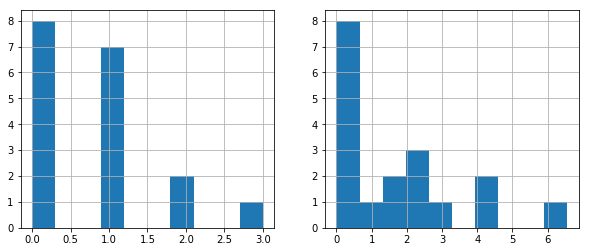

In [885]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
symmetry['difference (minutes)'].hist(ax=ax1)
symmetry['difference (percent)'].hist(ax=ax2)

When we only look at train routes (no bus connections), the difference between AM and PM is less pronounced. This is probably because there is no traffic.

*Frequency*

In [888]:
symmetry = pd.DataFrame()
for i,group in df.groupby(['hashcode_transport']):
    am = group[group.period == 'am']
    pm = group[group.period == 'pm']
    symmetry.loc[i,'N_am'] = am.shape[0]
    symmetry.loc[i,'N_pm'] = pm.shape[0]
    symmetry.loc[i,'am'] = am.sort_values('depart').depart.diff().dropna().mean()/60
    symmetry.loc[i,'pm'] = pm.sort_values('depart').depart.diff().dropna().mean()/60

In [889]:
symmetry['difference (minutes)'] = (symmetry.am - symmetry.pm).abs()
symmetry['difference (percent)'] = (symmetry.am - symmetry.pm).abs() / symmetry.am * 100

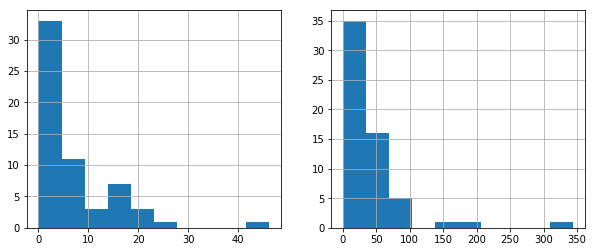

In [891]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
symmetry['difference (minutes)'].hist(ax=ax1)
symmetry['difference (percent)'].hist(ax=ax2)

Even though the difference in frequency is only 8 minutes, this corresponds to a percentage difference as high as 350%. This tells us that we cannot assume the network is directionless in regards to route frequency.

#### Symmetry in the direction of trips

In [960]:
symmetry = df.groupby(['route','direction']).length.mean().unstack()
symmetry['difference (minutes)'] = (symmetry[1] - symmetry[0]).abs()
symmetry['difference (percent)'] = (symmetry[1] - symmetry[0]).abs()/symmetry[0] * 100

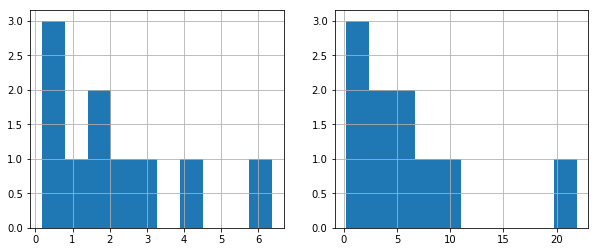

In [961]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
symmetry['difference (minutes)'].hist(ax=ax1)
symmetry['difference (percent)'].hist(ax=ax2)

We can see that, after excluding non-train trips, the time between directions differs by up to 8 minutes, or around 35% of the overall time duration. This is quite high. That being said, the trip length is usually within 10% between AM and PM.

#### Singularity

For this we check that for a given route, the duration of the trip is relatively the same. We treat trips in the morning and in the afternoon as different trips, since, as we saw in the previous section, their difference is significant.

In [942]:
trips_unique = df.groupby(['hashcode_transport','period'])

Text(0.5,1,'Standard deviation as percentage of mean')

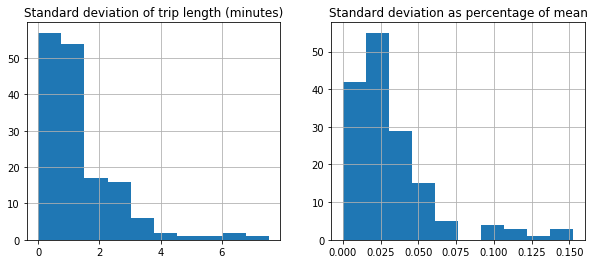

In [944]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
(trips_unique.length.std()).hist(ax=ax1)
(trips_unique.length.std() / trips_unique.length.mean()).hist(ax=ax2)
ax1.set_title('Standard deviation of trip length (minutes)')
ax2.set_title('Standard deviation as percentage of mean')

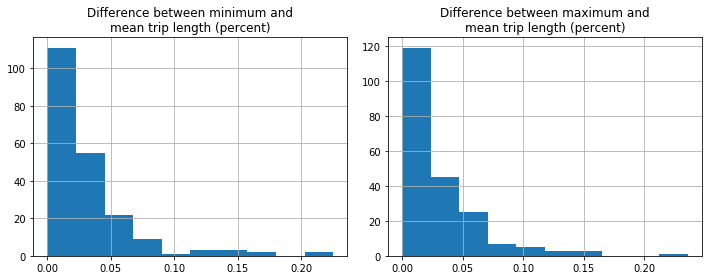

In [950]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
((trips_unique.length.min() - trips_unique.length.mean()).abs() / trips_unique.length.mean()).hist(ax=ax1)
((trips_unique.length.max() - trips_unique.length.mean()).abs() / trips_unique.length.mean()).hist(ax=ax2)
ax1.set_title('Difference between minimum and\nmean trip length (percent)')
ax2.set_title('Difference between maximum and\nmean trip length (percent)')
f.tight_layout()

We can see the standard deviation is usually low (around 2.5% of the overall trip length), but can be as high as 15%. When we look at max and min, the difference can reach up to over 20% (though is usually within 5%).

In [966]:
df.to_csv('../data/tripgo/sample.csv')

In [971]:
for i,seg in enumerate(segments):
    seg.to_csv('../data/tripgo/segments/segments_{}.csv'.format(i))

## API

Helper functions to extract the routes for a list of pairs of coordinates

In [843]:
def get_routes(depart_time, pairs, names):
    url = 'https://api.tripgo.com/v1/'
    
    headers = {
    'Accept': 'application/json',
    'X-TripGo-Key': '5c1a480843464d538b24939c266be8b9',
    }
    
    segments = []
    routes = []
    errors = []
    for i,pair in enumerate(pairs):
        try:
            print('Routing: from {} to {}'.format(names[i][0], names[i][1]))
            p2 = pair[0]
            p1 = pair[1]
            direction = i%2 # 0 for To and 1 for Return
            # Set up request
            params = (
                ('from', str(p2)),
                ('to', str(p1)),
                ('modes', 'pt_pub'),
                ('v', '11'),
                ('locale', 'en'),
                ('departAfter', depart_time - 1) #Subtract 1 since it's actually "depart after"
            )

            # Make request
            response = requests.get('https://api.tripgo.com/v1/routing.json', headers=headers, params=params)

            routing = json.loads(response.text)
            segs = pd.DataFrame(routing['segmentTemplates'])
            segs['route'] = int(i/2)
            segs['direction'] = direction
            segs['routeA'] = names[i][0]
            segs['routeB'] = names[i][1]
            segments.append(segs)

            # For all groups
            for j,group in enumerate(routing['groups']):
                df = pd.DataFrame(group['trips'])
                # Meta data
                df['route'] = int(i/2)
                df['direction'] = direction
                df['routeA'] = names[i][0]
                df['routeB'] = names[i][1]
                df['group'] = j
                df['num_segments'] = df.segments.apply(len)
                # Preliminary processing
                df['length'] = (df.arrive - df.depart)/60
                df['depart_time'] = df.depart.apply(datetime.fromtimestamp)
                df['arrive_time'] = df.arrive.apply(datetime.fromtimestamp)
                # Check if it's a completely underground route
                providers = ''
                for source in routing['groups'][j]['sources']:
                    name = source['provider']['name']
                    if ('Underground' not in name) and ('OpenStreetMap' not in name) and ('London Overground' not in name):
                        if len(providers):
                            providers += ', '
                        providers += name
                if providers == '':
                    # No other providers
                    providers = np.nan
                df['other_providers'] = providers
                routes.append(df)
        except Exception as e:
            print('Could no complete: {} to {}'.format(names[i][0],names[i][1]))
            print('Reason: ',e)
            errors.append(names[i])
            pass
    print('Complete.')
    return routes

In [846]:
time = datetime(2018,12,5,8,0).timestamp()

In [847]:
%%time

routes = get_routes(int(time),pairs,names)

Routing: from Shepherd's Bush 1 to Leicester Square
Routing: from Shepherd's Bush 1 to Chancery Lane
Routing: from Shepherd's Bush 1 to Euston
Routing: from Shepherd's Bush 1 to Baker Street
Routing: from Shepherd's Bush 1 to Hammersmith 1
Routing: from Shepherd's Bush 1 to Westminster
Routing: from Shepherd's Bush 1 to Paddington
Routing: from Shepherd's Bush 1 to South Kensington
Routing: from Shepherd's Bush 1 to Old Street
Routing: from Shepherd's Bush 1 to Warren Street
Routing: from Shepherd's Bush 1 to Stratford
Routing: from Shepherd's Bush 1 to Holborn
Routing: from Shepherd's Bush 1 to Piccadilly Circus
Routing: from Shepherd's Bush 1 to Farringdon
Routing: from Shepherd's Bush 1 to Tottenham Court Road
Routing: from Shepherd's Bush 1 to Green Park
Routing: from Shepherd's Bush 1 to Bond Street
Routing: from Shepherd's Bush 1 to Waterloo
Routing: from Shepherd's Bush 1 to Victoria
Routing: from Shepherd's Bush 1 to Moorgate
Routing: from Shepherd's Bush 1 to London Bridge
Rou

Routing: from Barking to King's Cross St. Pancras
Routing: from Barking to Liverpool Street
Routing: from Barking to Oxford Circus
Routing: from Barking to Canary Wharf
Routing: from Seven Sisters to Leicester Square
Routing: from Seven Sisters to Chancery Lane
Routing: from Seven Sisters to Euston
Routing: from Seven Sisters to Baker Street
Routing: from Seven Sisters to Hammersmith 1
Routing: from Seven Sisters to Westminster
Routing: from Seven Sisters to Paddington
Routing: from Seven Sisters to South Kensington
Routing: from Seven Sisters to Old Street
Routing: from Seven Sisters to Warren Street
Routing: from Seven Sisters to Stratford
Routing: from Seven Sisters to Holborn
Routing: from Seven Sisters to Piccadilly Circus
Routing: from Seven Sisters to Farringdon
Routing: from Seven Sisters to Tottenham Court Road
Routing: from Seven Sisters to Green Park
Routing: from Seven Sisters to Bond Street
Routing: from Seven Sisters to Waterloo
Routing: from Seven Sisters to Victoria
Rou

Routing: from London Bridge to Old Street
Routing: from London Bridge to Warren Street
Routing: from London Bridge to Stratford
Routing: from London Bridge to Holborn
Routing: from London Bridge to Piccadilly Circus
Routing: from London Bridge to Farringdon
Routing: from London Bridge to Tottenham Court Road
Routing: from London Bridge to Green Park
Routing: from London Bridge to Bond Street
Routing: from London Bridge to Waterloo
Routing: from London Bridge to Victoria
Routing: from London Bridge to Moorgate
Routing: from London Bridge to London Bridge
Could no complete: London Bridge to London Bridge
Reason:  'segmentTemplates'
Routing: from London Bridge to King's Cross St. Pancras
Routing: from London Bridge to Liverpool Street
Routing: from London Bridge to Oxford Circus
Routing: from London Bridge to Canary Wharf
Routing: from Brixton to Leicester Square
Routing: from Brixton to Chancery Lane
Routing: from Brixton to Euston
Routing: from Brixton to Baker Street
Routing: from Brix

In [849]:
df_routes = pd.concat(routes)

In [911]:
timestr = datetime.now().strftime('%Y%m%d_%H%M%S')
df_routes.to_csv('./output/routes_'+timestr+'.csv', index = False)